# Исследование о поездках на арендованных электросамокатах

Сервис аренды самокатов GoFast преоставил данные о некоторых пользователях из нескольких городов, а также об их поездках. 
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
 - **без подписки** (абонентская плата отсутствует; стоимость одной минуты поездки — 8 рублей; стоимость старта (начала поездки) — 50 рублей);
 - **с подпиской Ultra** (абонентская плата — 199 рублей в месяц;
стоимость одной минуты поездки — 6 рублей;
стоимость старта — бесплатно).

**Цель проекта:**
Проверка гипотезы о том, что пользователи, приобревшие подписку, приносят больший доход, чем пользователи без подписки.

**План проекта:**

1. Загрузка данных: в нашем распоряжении три файла:
- Пользователи — users_go.csv;
- Поездки — rides_go.csv;
- Подписки — subscriptions_go.csv.

2. Предобработка данных: 
- поиск пропущенных значений;
- заполнение пропущенных значений, где возможно;
- определение типа данных и в случае необходимости изменение на более подходящий;
- проверка на дубликаты и их обработка.

3. Исследовательский анализ данных. Описание и визуализация общей информации о пользователях и поездках:
- частота встречаемости городов;
- соотношение пользователей с подпиской и без подписки;
- возраст пользователей;
- расстояние, которое пользователь преодолел за одну поездку;
- продолжительность поездок.

4. Объединение данных:
- oбъединим данные о пользователях, поездках и подписках в один датафрейм. 
- разделим объединенный датафрейм на два по наличию подписки.
- визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

5. Подсчет выручки: определить помесячный доход от каждого пользователя

6. Проверка гипотез:
- понять, тратят ли пользователи с подпиской больше времени на поездки?
- можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
- будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from scipy import stats as st
from scipy.stats import binom, norm
from math import sqrt

## Шаг 1. Загрузка данных

Загрузим три таблицы с помощью метода `read_csv()`, изучим общую информацию методом `info()`, а также выведем на экран первые пять строк каждой таблицы методом `head()`

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
rides = pd.read_csv('/datasets/rides_go.csv')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [5]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [7]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Вывод: во всех трех таблицах нет пропущенных значений, названия столбцов корректно указаны (не требуют исправлений), типы данных также корректы везде, кроме столбца `date` в датафрейме `rides`.
На следующем этапе займусь этим столбцом и проверкой на дубликаты.**

## Шаг 2. Предобработка данных

### Приведение столбца date к типу даты pandas.

Воспользуемся методом `to_datetime()`

In [8]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

Проверим, за какой период предоставлены данные

In [9]:
rides['date'].min(), rides['date'].max()

(Timestamp('2021-01-01 00:00:00'), Timestamp('2021-12-30 00:00:00'))

У нас имеются данные за весь 2021 год с января до конца декабря, для дальнейшего исследования логичным будет 
добавление нового столбца с номером месяца.

### Создание нового столбца с номером месяца

In [10]:
rides['month'] = rides['date'].dt.month
rides['month'].unique()

array([ 1,  4,  8, 10, 11, 12,  3,  6,  7,  2,  5,  9])

### Обработка дубликатов

Прежду чем искать дубликаты, посмотрим, какие уникальные значения в каждом строковом столбце, возможно присутствуют неявные дубликаты.

In [11]:
users['name'].unique()

array(['Кира', 'Станислав', 'Алексей', 'Константин', 'Адель', 'Регина',
       'Игорь', 'Юрий', 'Ян', 'Валерий', 'Агата', 'Марк', 'Ева',
       'Антонина', 'Валерия', 'Амалия', 'Даниил', 'Аделина', 'Святогор',
       'Борис', 'Вероника', 'Ростислав', 'Назар', 'Эдуард', 'Василий',
       'Денис', 'Тамара', 'Николай', 'Эвелина', 'Федор', 'Руслан', 'Иван',
       'Любовь', 'Ярослава', 'Майя', 'Ильдар', 'Данила', 'Нина',
       'Стефания', 'Ясмина', 'Дмитрий', 'Александр', 'Одиссей', 'Арсений',
       'Алла', 'Таисия', 'Максим', 'Юлиана', 'Павел', 'Карина', 'Алиса',
       'Лидия', 'Рамиль', 'Родион', 'Ника', 'Оксана', 'Анастасия',
       'Маргарита', 'Вера', 'Тимур', 'Никита', 'Лев', 'Влад', 'Артур',
       'Анна', 'Ольга', 'Вячеслав', 'Ксения', 'Виталина', 'Владислав',
       'Тамерлан', 'Амина', 'Вадим', 'Олеся', 'Зарина', 'Егор', 'Гордей',
       'Лилия', 'Святослав', 'Роберт', 'Амир', 'Влада', 'Богдан',
       'Полина', 'Марат', 'Елисей', 'Макар', 'Алина', 'Глеб', 'Андрей',
       'Ал

In [12]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

С данными все в порядке. Теперь можно проверять на явные дубликаты

In [13]:
users.duplicated().sum()

31

In [14]:
# удаляем дубликаты
users = users.drop_duplicates()
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


В таблице с пользователями дубликаты удалены, приступаем к поездкам

In [15]:
rides.duplicated().sum()

0

Дубликаты не найдены.

**Вывод по предобработке данных: предоставленные данные без пропусков, корректно заполнены названия столбцов и сами столбцы, тип данных изменен только в столбце с датой, остальные типы данных подходят для дальнейшего исследования, из таблицы с пользователями удален 31 дубликат.**

## Шаг 3. Исследовательский анализ данных

In [16]:
%config InlineBackend.figure_format = 'retina' # улучшение четкости изображения графиков

### Частота встречаемости городов

In [17]:
# сгруппируем users по городам и посчитаем их количество, отсортируем в порядке убывания
users.groupby('city')['city'].agg('count').sort_values(ascending=False)

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

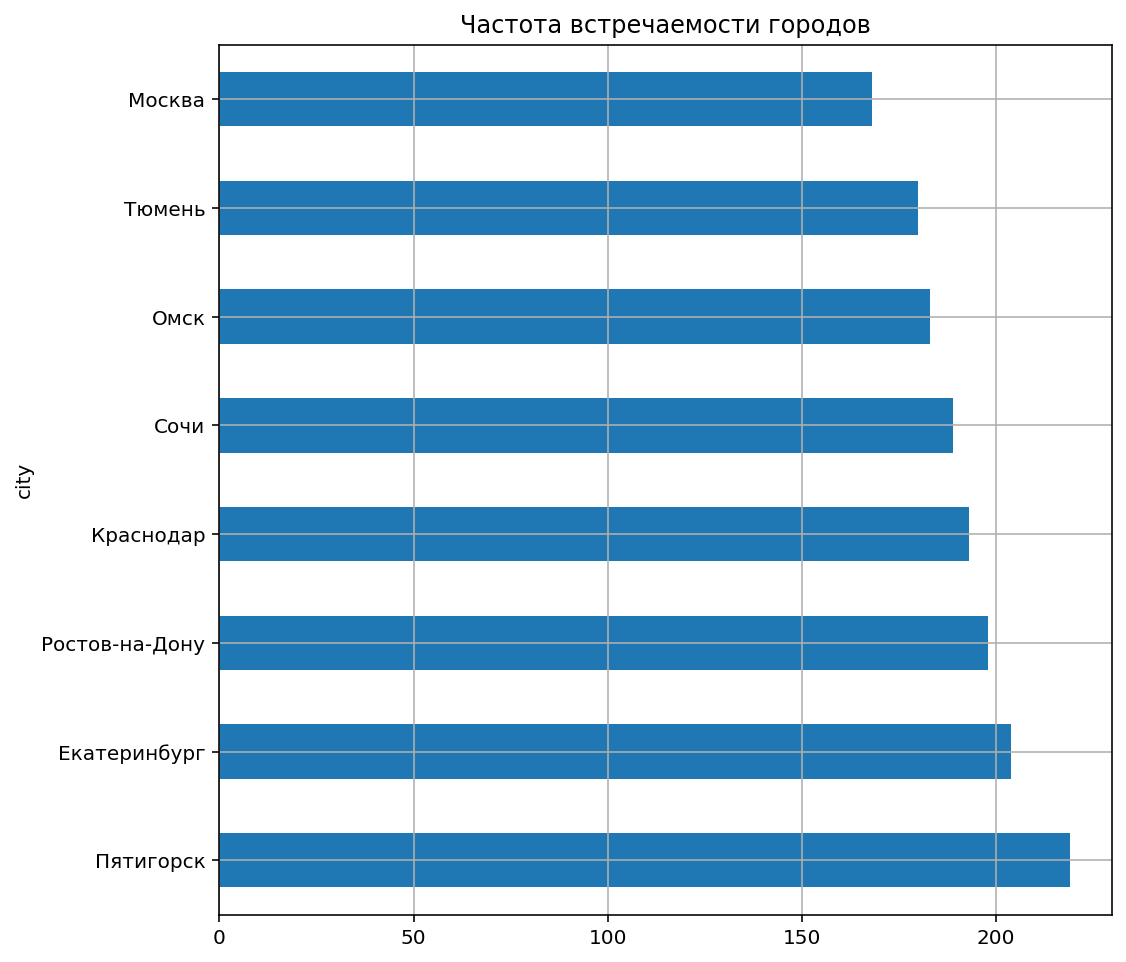

In [18]:
# построим горизонтальный барплот
(users.groupby('city')['city'].agg('count').sort_values(ascending=False)
 .plot(kind='barh', figsize=(8, 8), title='Частота встречаемости городов', grid=True))

plt.show()

**Вывод: за 2021 год в каждом из восьми городов к сервису проката самокатов подключилось от 168 до 219 пользователей. Видно, что южные города (Пятигорск (219), Ростов-на-Дону (198), Краснодар (193) и Сочи (189)) немного больше используют сервис самокатов, предполагаю, причина в климате и количестве теплых дней и короткой зиме, поэтому самокаты используются больше. Таким образом объяснимо, почему меньше зарегистрированных пользователей в Омске (183) и в Тюмени (180) - зима длиннее, а самое малое количество пользователей в Москве (168), думаю, из-за конкуренции сервисов, предоставляющих такую же услугу. Екатеринбург (204) - также в лидерах по использованию, затрудняюсь ответить почему, возможно, хорошо развита инфраструктура (веломаршруты, широкие тротуары).**

### Соотношение пользователей с подпиской и без подписки

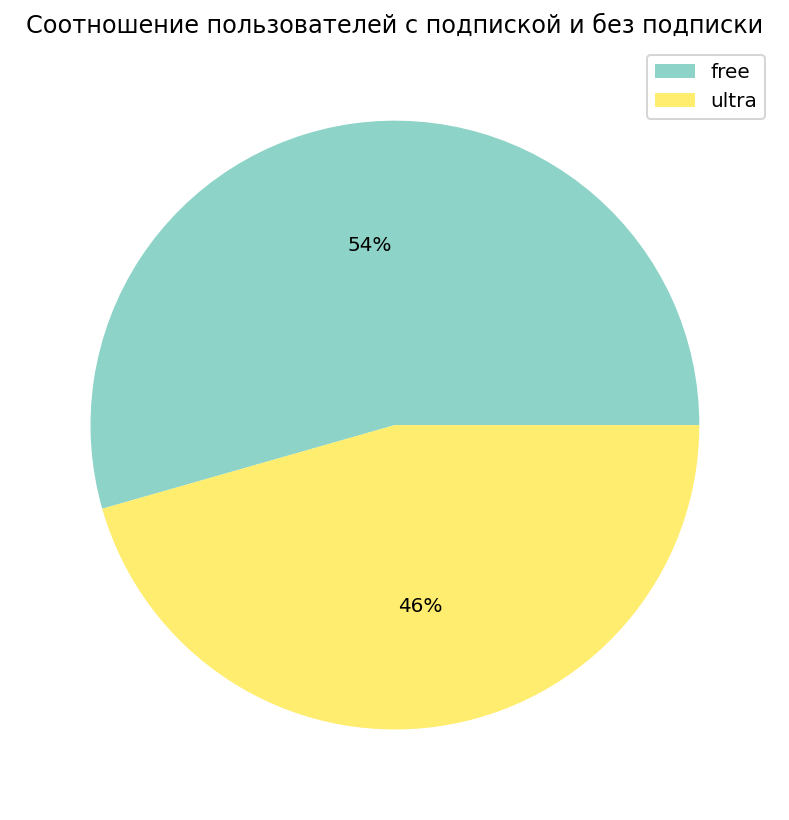

In [19]:
# построим круговую диаграмму
# сгруппируем users по типу подписки и посчитаем их количество
# вид диаграммы - круговая, на самой диаграмме не будем указывать тип подписки, а добавим их в легенду
# а на диаграмме укажем долю каждого типа подписки autopct='%1.0f%%'
# укажем название диаграммы и применим цветовую схему с помощью параметра cmap
(users.groupby('subscription_type')['subscription_type'].agg('count')
 .plot(kind='pie', labels=None, label='', autopct='%1.0f%%', legend=True, figsize=(7, 7), 
       title='Соотношение пользователей с подпиской и без подписки', cmap='Set3'))
plt.show()

<div class="alert alert-block alert-success">
<b>✅Комментарий ревьюера:</b> А вот тут круговая диаграмма отлично подходит!</div>

**Вывод: большая часть пользователей самокатов предпочитает не приобретать подписку, их 54% по сравнению с теми, кто оформил подписку**

###  Возраст пользователей

In [20]:
matplotlib.style.use('seaborn-pastel') # применим стиль matplotlib

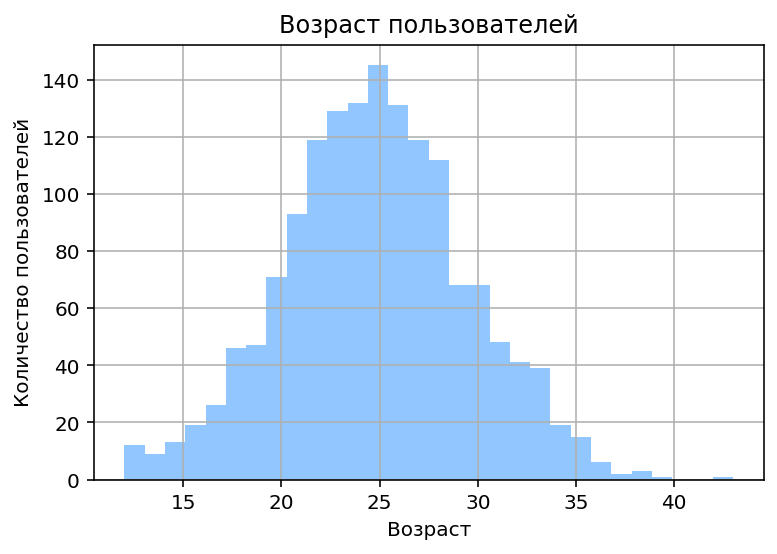

In [21]:
users.hist(column='age', bins=30) # построим гистограмму
plt.grid(True) # используем сетку
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

In [22]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

**Вывод: среди пользователей самокатов лица от 12 до 43 лет, основные пользователи с возрастом от 22 до 28 лет, при  этом средний возраст около 25 лет, он и является самым популярным**

### Расстояние, которое пользователь преодолел за одну поездку

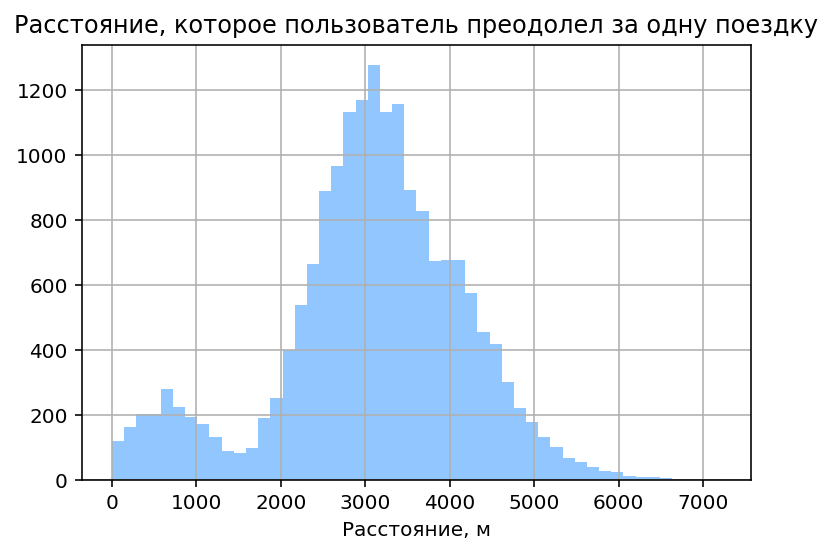

In [23]:
rides.hist(column='distance', bins=50) # построим гистограмму
plt.grid(True) # используем сетку
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние, м')
plt.show()

In [24]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

**Вывод: в среднем пользователи проезжают 3км, 75% пользователей проезжают расстояние от 2,5 км до 4 км. Меньше 25% пользователей проезжают до 2км или более 4 км. Максимальное зафиксированное расстоние 7,2 км.**

**На диаграмме выделены два пика: первый 750 м на расстоянии до 1,5 км, а второй 3 км в пределах от 1,5 км до 6 км. Предполагаю, это потому что пользователи используют самокат в двух разных целях: проехать короткую дистанцию (до 1,5 км, в случае пересадки на общественный транспорт, когда, например, от дома до автобусной остановки или до станции электрички идти далеко) или длинную (в этом случае, можно полностью проехать весь маршрут без пересадки на общественный транспорт)**

### Продолжительность поездок

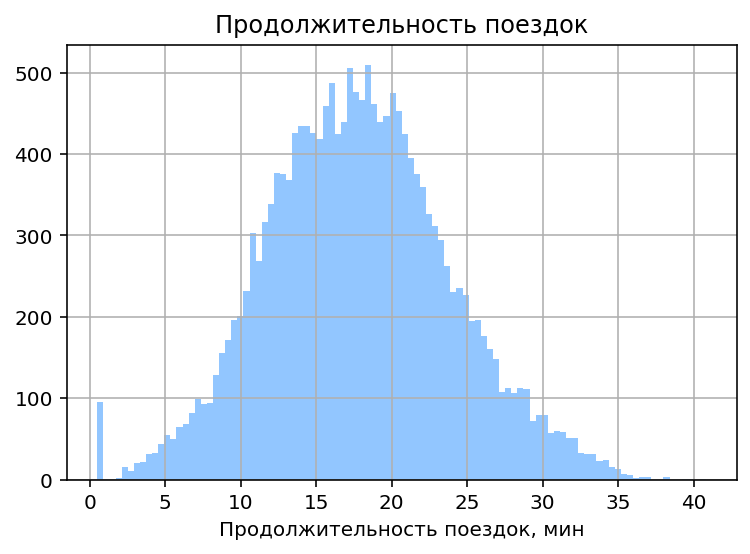

In [25]:
rides.hist(column='duration', bins=100) # построим гистограмму
plt.grid(True) # используем сетку
plt.title('Продолжительность поездок')
plt.xlabel('Продолжительность поездок, мин')
plt.show()

In [26]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

**Вывод: все поездки укладываются в 40 мин, в основном поездки длятся от 13 до 25 мин.**

**На диаграмме видим странный пик, когда практически сто пользователей завершили поездку в первые две минуты, т.е. сразу при старте, я бы не исключала такие данные. Возможно это сигнал, что сервис недостаточно понятен пользователям и необходимо рассмотреть доработку.**

## Шаг 4. Объединение данных

### Объединение данные о пользователях, поездках и подписках в один датафрейм

In [27]:
# воспользуемся методом merge()
# объединяем users и rides по столбцу user_id
users_rides = users.merge(rides, on='user_id', how='left')
# объединяем получившийся датафрейм users_rides и subscriptions по subscription_type
data = users_rides.merge(subscriptions, on='subscription_type', how='left')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


### Получение двух датафреймов в зависимости от подписки

In [28]:
# пользователи с подпиской
# сделаем срез по data методом query()
data_ultra = data.query('subscription_type == "ultra"')
data_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   float64       
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int64         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB


In [29]:
# пользователи без подписки
# сделаем срез по data методом query()
data_free = data.query('subscription_type == "free"')
data_free.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   distance           11568 non-null  float64       
 6   duration           11568 non-null  float64       
 7   date               11568 non-null  datetime64[ns]
 8   month              11568 non-null  int64         
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB


### Визуализация информации о расстоянии и времени поездок для пользователей обеих категорий

In [30]:
matplotlib.style.use('bmh') 

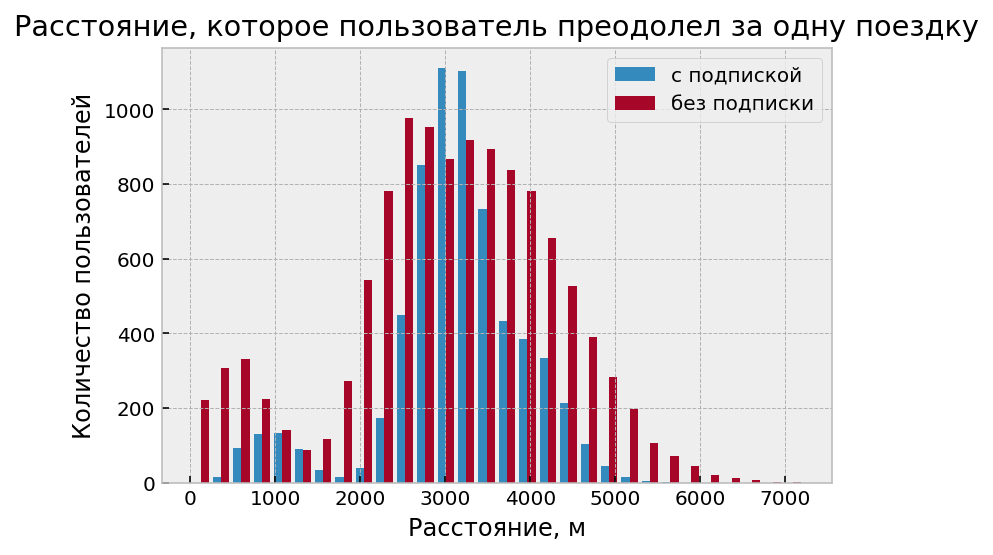

In [31]:
# построим гистограммы расстояния для обеих групп пользователей, наложив их друг на друга
plt.hist([data_ultra['distance'], data_free['distance']], bins=30, label=['с подпиской', 'без подписки'])
plt.grid(True) # используем сетку
plt.legend(loc='upper right') # добавим легенду в правом верхнем углу
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество пользователей')
plt.show()

**В целом пользователей без подписки больше, чем с подпиской, что и показывает график. В обеих группах пользователей два пика, что говорит о том, что независимо от подписки в обеих группах есть пользователи, которые используют самокат только на короткие поездки. Чем уже график, тем стандартное отклонение меньше, это можно сказать о данных по пройденному расстоянию для пользователей с подпиской, их основное расстоние - 3км, а вот для пользователей без подписки не так все четко прослеживается, я бы назвала промежуток от 2,5 км до 4км. Пользователи без пописки чаще заканчивают свой маршрут на самокате проехав 1км, при этом пользователи без подписки чаще проезжают расстояние 5 км, чем с подпиской.**

In [32]:
matplotlib.style.use('ggplot') 

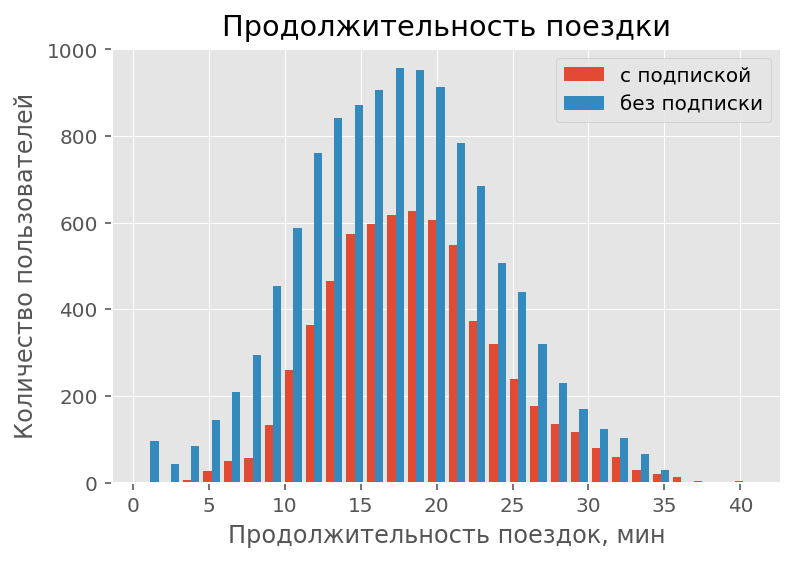

In [33]:
# построим гистограммы продолжительности поездок для обеих групп пользователей, наложив их друг на друга
plt.hist([data_ultra['duration'], data_free['duration']], bins=30, label=['с подпиской', 'без подписки'])
plt.grid(True) # используем сетку
plt.legend(loc='upper right') # добавим легенду в правом верхнем углу
plt.title('Продолжительность поездки')
plt.xlabel('Продолжительность поездок, мин')
plt.ylabel('Количество пользователей')
plt.show()


**Вывод: обе гистрограммы очень похожи в части средней продолжительности поездки (15-20 мин), но отличаются своими хвостами: пользователи без подписки чаще сдают самокаты обратно на первых минутах (возможно, не смогли разобраться с сервисом или самокатом), при этом пользователей без подписки, проехавших свыше 30 мин, больше, это соответствует и тому, что расстояние они проезжают больше.**

## Шаг 5. Подсчёт выручки

 Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц, а также добавим информацию о типе подписки.
После этого в тот же датафрейм добавим столбец с помесячной выручкой на основе данных о стоимости из таблицы `subscription`

In [34]:
# округлим суммарную продолжительность поездки до следующего целого числа
# т.к. оплата списывается за каждую начатую минуту
data['duration'] = np.ceil(data['duration'])

In [35]:
# воспользуемся методом groupby() и сгруппируем по пользователю и месяцу
# найдем сумму расстояний, сумму затраченного времени, количество поездок
# для дальнейших расчетов нам понадобися информация по типу подписки, поэтому также применим 
# агрегированную функцию для этого столбца и выберем первое значение 'first'
data_grouped = (data.groupby(['user_id', 'month',])
               .agg({'distance': 'sum', 'duration':'sum', 'user_id': 'count', 'subscription_type':'first',
               'minute_price': 'first', 'start_ride_price': 'first', 'subscription_fee': 'first'}))
# чтобы проще было обращаться к новым столбцам применим метод columns
data_grouped.columns = ['distance_sum', 'duration_sum', 'rides_count', 'subscription_type', 'minute_price', \
                       'start_ride_price', 'subscription_fee']

data_grouped['duration_sum'] = np.ceil(data_grouped['duration_sum']) 
data_grouped

distance_sum  duration_sum  rides_count subscription_type  \
user_id month                                                              
1       1       7027.511294          42.0            2             ultra   
        4        754.159807           7.0            1             ultra   
        8       6723.470560          46.0            2             ultra   
        10      5809.911100          32.0            2             ultra   
        11      7003.499363          56.0            3             ultra   
...                     ...           ...          ...               ...   
1534    6       3409.468534          26.0            2              free   
        8       7622.453034          48.0            2              free   
        9       4928.173852          23.0            1              free   
        11     13350.015305          78.0            4              free   
        12      2371.711192          16.0            1              free   

               minute_price  start_ride_price  subscription_fee  
user_id month                                                    
1       1                 6                 0               199  
        4                 6                 0               199  
        8                 6                 0               199  
        10                6                 0               199  
        11                6                 0               199  
...                     ...               ...               ...  
1534    6                 8                50                 0  
        8                 8                50                 0  
        9                 8                50                 0  
        11                8                50                 0  
        12                8                50                 0  

[11331 rows x 7 columns]

In [36]:
data_grouped.columns # проверим названия столбцов, к которым можем обращаться

Index(['distance_sum', 'duration_sum', 'rides_count', 'subscription_type',
       'minute_price', 'start_ride_price', 'subscription_fee'],
      dtype='object')

In [37]:
# рассчитаем помесячную выручку от каждого пользователя и добавим результат в новый столбец 'revenue'
data_grouped['revenue'] = data_grouped['start_ride_price'] * data_grouped['rides_count'] + \
                         data_grouped['minute_price'] * data_grouped['duration_sum'] + \
                         data_grouped['subscription_fee']
data_grouped.head()

distance_sum  duration_sum  rides_count subscription_type  \
user_id month                                                              
1       1       7027.511294          42.0            2             ultra   
        4        754.159807           7.0            1             ultra   
        8       6723.470560          46.0            2             ultra   
        10      5809.911100          32.0            2             ultra   
        11      7003.499363          56.0            3             ultra   

               minute_price  start_ride_price  subscription_fee  revenue  
user_id month                                                             
1       1                 6                 0               199    451.0  
        4                 6                 0               199    241.0  
        8                 6                 0               199    475.0  
        10                6                 0               199    391.0  
        11                6                 0               199    535.0

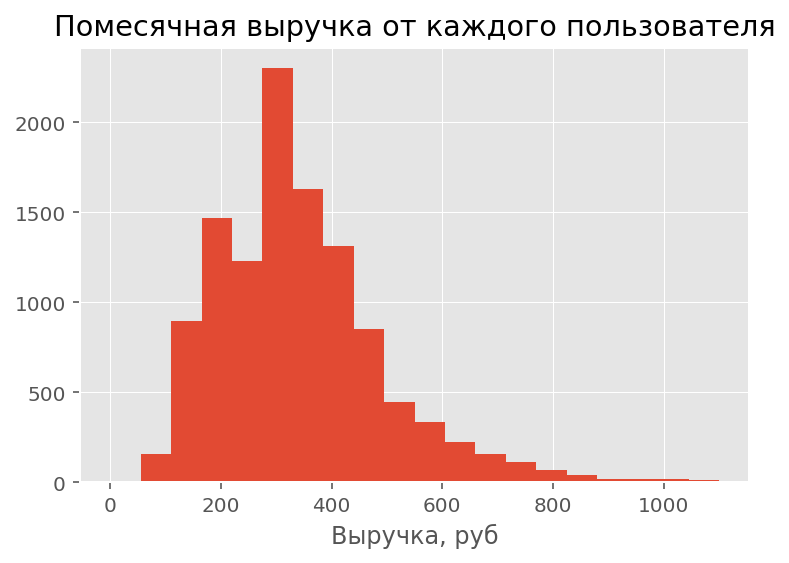

In [38]:
data_grouped.hist(column='revenue', bins=20, range=(0, 1100)) # построим гистограмму
plt.grid(True) # используем сетку
plt.title('Помесячная выручка от каждого пользователя')
plt.xlabel('Выручка, руб')
plt.show()

**Вывод: в среднем каждый пользователь в месяц тратит 300 руб на поездку на самокатах.**

Проверим выручку в зависимости от типа подписки

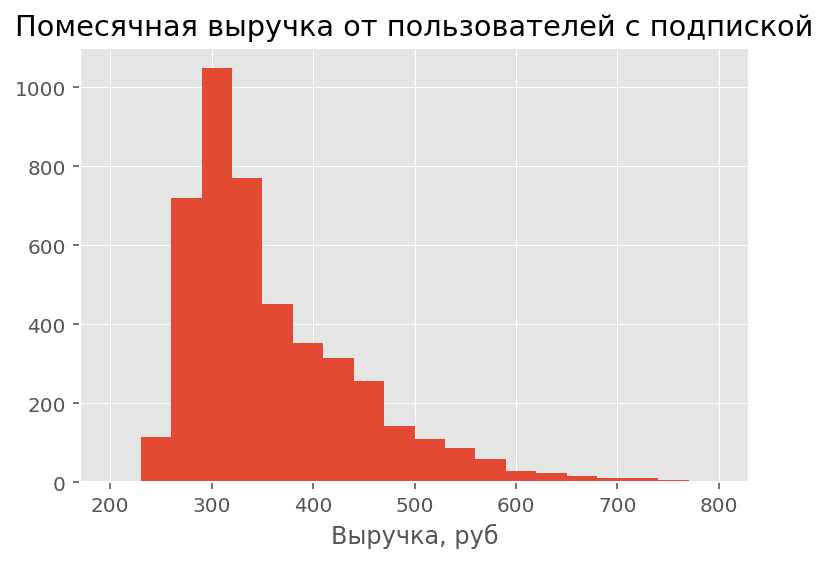

In [39]:
data_grouped.query('subscription_type == "ultra"').hist(column='revenue', bins=20, range=(200, 800))
plt.grid(True) # используем сетку
plt.title('Помесячная выручка от пользователей с подпиской')
plt.xlabel('Выручка, руб')
plt.show()

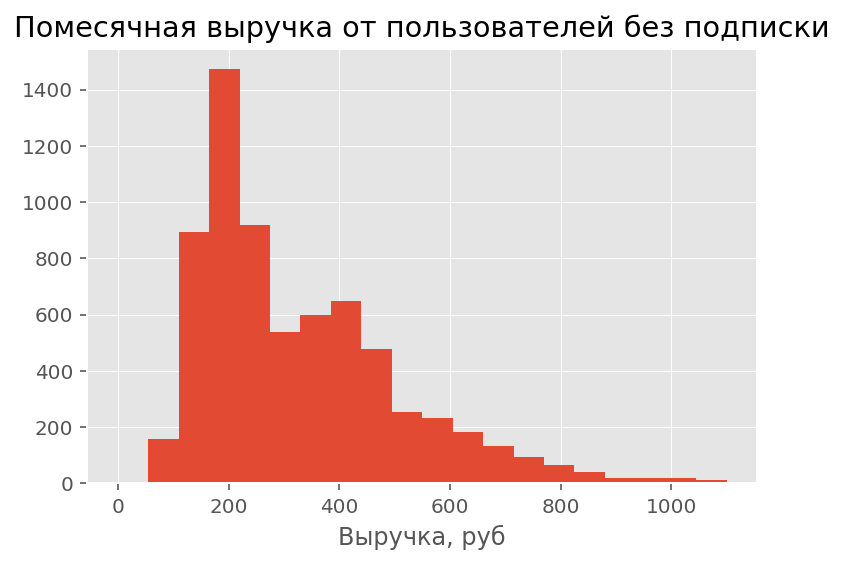

In [40]:
data_grouped.query('subscription_type == "free"').hist(column='revenue', bins=20, range=(0, 1100))
plt.grid(True) # используем сетку
plt.title('Помесячная выручка от пользователей без подписки')
plt.xlabel('Выручка, руб')
plt.show()

**Вывод: средняя выручка у пользователей с подпиской на 100 руб больше, чем у пользователей без подписки и т.к. пользователей без подписки гораздо больше, чем с подпиской, кажется логичным решение в необходимости увеличения числа пользователей с подпиской для увеличения выручки.**

## Шаг 6. Проверка гипотез

### Гипотеза о затраченном времени

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим эту гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков `data_ultra['duration']` и тех, у кого нет подписки `data_free['duration']`.

Нулевая гипотеза: средние значения затраченного времени пользователей из двух групп равны.

Альтернативная гипотеза: среднее значение затраченного времени пользователей с подпиской больше, чем среднее значение затраченного времени пользователей без подписки.

Чтобы проверить такую гипотезу, нужно передать в метод `ttest_ind()` сначала выборку с затраченным времем пользователей с подпиской `data_ultra['duration']`, затем выборку с затраченным времем пользователей без подписки `data_free['duration']`. В качестве `alternative` нужно указать `'greater'`.

In [41]:
alpha = 0.05 # уровень статистической значимости
results_duration = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater')
print('p-значение:', results_duration.pvalue)

p-значение: 1.2804098316645618e-34


In [42]:
if results_duration.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу


**Вывод: нулевая гипотеза о том, что средние значения затраченного времени пользователей из двух групп равны отвергнута в пользу альтернативной: среднее значение затраченного времени пользователей с подпиской больше, чем среднее значение затраченного времени пользователей без подписки.**

**Таким образом, в среднем пользователи с подпиской тратят больше времени на поездки.**

### Гипотеза о среднем расстоянии

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверим эту гипотезу.

Нулевая гипотеза: среднее оптимальное расстояние пользователей с подпиской равно 3130м.

Альтернативная гипотеза: среднее оптимальное расстояние пользователей с подпиской больше 3130м.

Чтобы проверить такую гипотезу, нужно передать в метод `ttest_1samp()` выборку с расстоянием, которое проезжают пользователи с подпиской за одну поездку `data_ultra['distance']`, `distance_opt` - предполагаемое среднее, на равенство которому делаем тест. В качестве `alternative` нужно указать `'less'`.

In [43]:
distance_opt = 3130 # оптимальное расстояние
results_distance = st.ttest_1samp(data_ultra['distance'], distance_opt, alternative='greater')

print('p-значение:', results_distance.pvalue)

if (results_distance.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


**Вывод: нулевая гипотеза не отвергнута, значит, мы можем сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.**

### Гипотеза о помесячной выручке

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Нулевая гипотеза: средние значения помесячной выручки пользователей из двух групп равны.

Альтернативная гипотеза: среднее значение помесячной выручки пользователей с подпиской больше, чем среднее значение помесячной выручки пользователей без подписки.

Чтобы проверить такую гипотезу, нужно передать в метод `ttest_ind()` сначала выборку с помесячной выручкой пользователей с подпиской, затем выборку с помесячной выручкой пользователей без подписки. В качестве `alternative` нужно указать `'greater'`.

In [44]:
# значения помесячной выручки для пользователей с подпиской
data_revenue_ultra = data_grouped.query('subscription_type == "ultra"')['revenue']
# значения помесячной выручки для пользователей без подписки
data_revenue_free = data_grouped.query('subscription_type == "free"')['revenue']

In [45]:
results_revenue = st.ttest_ind(data_revenue_ultra, data_revenue_free, alternative='greater')
print('p-значение:', results_revenue.pvalue)

p-значение: 1.8850394384715216e-31


In [46]:
if results_duration.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу


**Вывод: нулевая гипотеза о том, что средние значения помесячной выручки пользователей из двух групп равны отвергнута в пользу альтернативной: среднее значение помесячной выручки пользователей с подпиской больше, чем среднее значение помесячной выручки пользователей без подписки.**

**Таким образом, в среднем пользователи с подпиской приносят большую выручку, чем пользователи без подписки.**

### Гипотеза о результатах обновления сервиса

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Ответ: 
в этом случае нулевая гипотеза будет проверять равенство количества обращений в техподдержку до и после обновления, поэтому здесь необходимо использовать гипотезу о равенстве средних для зависимых (парных) выборок.**

**В этом случае применяем метод `scipy.stats.ttest_rel()`. Ему достаточно передать всего два параметра: наборы данных до и после. Оба набора должны быть одинаковыми по размеру: каждое измерение должно быть проведено до и после изменения.**

## Шаг 7. Распределения

### Задача о количестве рассылаемых промокодов

 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

In [47]:

p = 0.1 # вероятность
# нужно разослать 1000 прокодов, чтобы получить 100 новых клиентов при 100% вероятности
n = 1000 
k = 99
# теперь найдем n для 5% вероятности невыполнения плана
while binom.cdf(k, n, p) > 0.05:
    n += 1

n

1161

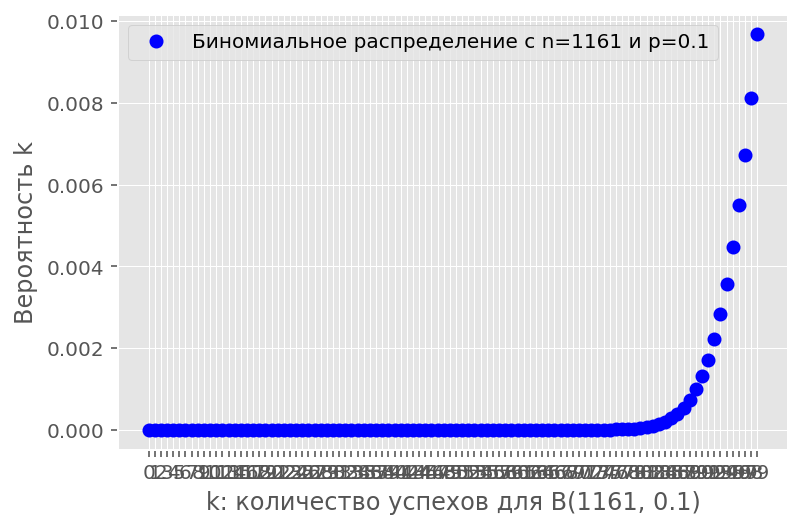

In [48]:
# задаем диапазон значений k для построения графика
 
binom_probs = []

# для всех значений от 0 до 1000
for k in range(k + 1):
    # рассчитываем значения вероятности для биномиального распределения
    binom_prob = binom.pmf(k, n, p)
    # добавляем в соответствующие списки
    binom_probs.append(binom_prob)
    
plt.plot(range(k + 1), binom_probs, 'bo',
         label=f'Биномиальное распределение с n={n} и p={p}')
plt.xlabel(f'k: количество успехов для B{n, p}')
plt.ylabel('Вероятность k')
plt.legend()
plt.xticks(range(k + 1))
plt.show()

**Вывод: необходимо разослать минимум 1161 промокод для получения новых 100 пользователей, чтобы вероятность не выполнить план была примерно 5%.**

In [49]:
# код ревьюера
binom.cdf(99, 1161, 0.1)

0.04976090094990249

### Задача о вероятности открытия push-уведомления

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 
40 % получивших клиентов. Отдел планирует разослать 
1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 
399,5 тыс. пользователей.

In [50]:
# параметры биномиального распределения
n_2 = 1000000  
p_2 = 0.4  
# параметры нормального распределения
mu_2 = n_2 * p_2 
sigma_2 = sqrt(n_2 * p_2 * (1 - p_2))

distr_2 = st.norm(mu_2, sigma_2) # задаем нормальное распределение

result_2 = distr_2.cdf(399500) # находим вероятность хвоста слева
result_2

0.15371708296369768

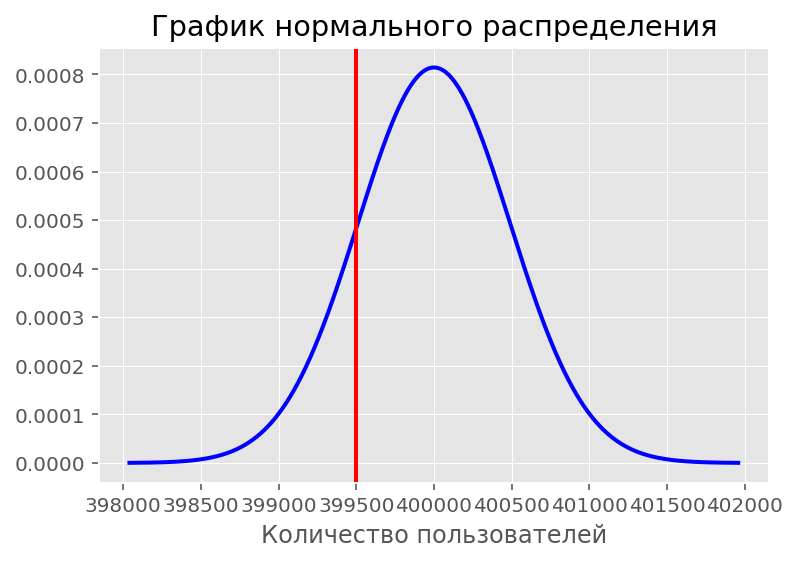

In [51]:
# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n_2 * p_2 - 4 * sqrt(n_2 * p_2 * (1 - p_2)))
right = int(n_2 * p_2 + 4 * sqrt(n_2 * p_2 * (1 - p_2)))
# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
# рисуем график нормального распределения:
plt.plot(x, st.norm.pdf(x, mu_2, sigma_2), 'b-')
# рисуем вертикальную линию в точке 399,5 тыс. пользователей, чтобы было видно левый хвост
plt.axvline(x=399500, color='red') 
plt.title('График нормального распределения')
plt.xlabel('Количество пользователей')
plt.show()

**Вывод: Если будет разослано 1 млн уведомлений, которые открываются с вероятностью 40%, то вероятность того, что уведомление откроют не более 399,5 тыс. пользователей составляет 15%.**

## Общий вывод

**Целью** проекта была проверка гипотезы о том, что пользователи, приобревшие подписку, 
приносят больший доход, чем пользователи без подписки.

Для реализации этой цели были проанализированы три файла с данными:
  - данные о пользователях;
  - данные о поездках;
  - данные о тарифах.

Прежде чем приступать к анализу была проведена **предобработка данных**. 
Предоставленные данные без пропусков, корректно заполнены названия столбцов и сами столбцы, 
тип данных изменен только в столбце с датой, 
из таблицы с пользователями удален 31 дубликат.

По результатам **исследовательского анализа данных** были сделаны следующие выводы:

   - за 2021 год в каждом из восьми городов к сервису проката самокатов подключилось от 168 до 219 пользователей. Видно, что южные города (Пятигорск (219), Ростов-на-Дону (198), Краснодар (193) и Сочи (189)) немного больше используют сервис самокатов, предполагаю, причина в климате и количестве теплых дней и короткой зиме, поэтому самокаты используются больше. Таким образом объяснимо, почему меньше зарегистрированных пользователей в Омске (183) и в Тюмени (180) - зима длиннее, а самое малое количество пользователей в Москве (168), думаю, из-за конкуренции сервисов, предоставляющих такую же услугу. Екатеринбург (204) - также в лидерах по использованию, затрудняюсь ответить почему, возможно, хорошо развита инфраструктура (веломаршруты, широкие тротуары).
    
   - соотношение пользователей с подпиской и без: большая часть пользователей самокатов предпочитает
    не приобретать подписку, их 54% по сравнению с теми, кто оформил подписку.
    
   - возраст пользователей: среди пользователей самокатов лица от 12 до 43 лет,
    основные пользователи с возрастом от 22 до 28 лет, 
    при  этом средний возраст около 25 лет, он и является самым популярным
    
   - в среднем пользователи проезжают 3км, 75% пользователей проезжают расстояние от 2,5 км до 4 км. 
    Меньше 25% пользователей проезжают до 2км или более 4 км. Максимальное зафиксированное расстоние 7,2 км.
    
   - все поездки укладываются в 40 мин, в основном поездки длятся от 13 до 25 мин.
    
**Подсчет выручки**: в среднем каждый пользователь в месяц тратит 300 руб на поездку на самокатах.
средняя выручка у пользователей с подпиской на 100 руб больше, чем у пользователей без подписки
и т.к. пользователей без подписки гораздо больше, чем с подпиской, кажется логичным решение 
в необходимости увеличения числа пользователей с подпиской для увеличения выручки.

**Проверка гипотез**:

   - нулевая гипотеза о том, что средние значения затраченного времени пользователей
    из двух групп равны отвергнута в пользу альтернативной: среднее значение затраченного времени пользователей
    с подпиской больше, чем среднее значение затраченного времени пользователей без подписки.
    Таким образом, в среднем пользователи с подпиской тратят больше времени на поездки.
    
   - среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.
    
   - нулевая гипотеза о том, что средние значения помесячной выручки пользователей из двух групп
    равны отвергнута в пользу альтернативной: среднее значение помесячной выручки пользователей
    с подпиской больше, чем среднее значение помесячной выручки пользователей без подписки.
    
**Таким образом, в среднем пользователи с подпиской приносят большую выручку, чем пользователи без подписки**

**Распределения:**
    - необходимо разослать минимум 1130 промокодов, чтобы получить новых 100 пользователей с вероятностью 95%.
    - если будет разослано 1 млн уведомлений, которые открываются с вероятностью 40%, то вероятность того, 
    что уведомление откроют не более 399,5 тыс. пользователей составляет 15%.
